In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def vc (dataframe : pd.DataFrame, column : str, print_all = False):  # A quick function to print off value counts of a dataframe
    if print_all:
        for category in dataframe.columns.values.tolist():
            print(category.upper())
            print(dataframe[category].value_counts())
            print()
    else:
        print(column.upper())
        print(dataframe[column].value_counts())

In [3]:
df = pd.read_csv('data/Significant_Earthquakes_1965-2016.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [5]:
df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [6]:
type(df.Latitude[1])

numpy.float64

In [7]:
df.describe()

,Latitude,Longitude,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square
count,23412.000000,23412.000000,23412.000000,4461.000000,7097.000000,23412.000000,327.000000,2564.000000,7299.000000,1604.000000,1156.000000,17352.000000
mean,1.679033,39.639961,70.767911,4.993115,275.364098,5.882531,0.071820,48.944618,44.163532,3.992660,7.662759,1.022784
std,30.113183,125.511959,122.651898,4.875184,162.141631,0.423066,0.051466,62.943106,32.141486,5.377262,10.430396,0.188545
min,-77.080000,-179.997000,-1.100000,0.000000,0.000000,5.500000,0.000000,0.000000,0.000000,0.004505,0.085000,0.000000
25%,-18.653000,-76.349750,14.522500,1.800000,146.000000,5.600000,0.046000,10.000000,24.100000,0.968750,5.300000,0.900000
50%,-3.568500,103.982000,33.000000,3.500000,255.000000,5.700000,0.059000,28.000000,36.000000,2.319500,6.700000,1.000000
75%,26.190750,145.026250,54.000000,6.300000,384.000000,6.000000,0.075500,66.000000,54.000000,4.724500,8.100000,1.130000
max,86.005000,179.998000,700.000000,91.295000,934.000000,9.100000,0.410000,821.000000,360.000000,37.874000,99.000000,3.440000


In [8]:
vc(df,"no",True)

DATE
03/11/2011    128
12/26/2004     51
02/27/2010     39
02/06/2013     27
11/15/2006     25
             ... 
10/14/2002      1
06/30/1986      1
01/17/2009      1
02/24/1993      1
01/18/1970      1
Name: Date, Length: 12401, dtype: int64

TIME
02:56:58    5
14:09:03    5
09:18:32    4
16:25:34    4
06:29:16    4
           ..
00:33:52    1
10:18:51    1
12:21:39    1
09:05:34    1
17:43:36    1
Name: Time, Length: 20472, dtype: int64

LATITUDE
-5.902     5
-5.589     5
 51.500    5
-5.605     5
-4.694     4
          ..
 1.507     1
 35.241    1
 76.208    1
 34.825    1
-13.698    1
Name: Latitude, Length: 20676, dtype: int64

LONGITUDE
 126.777    5
 126.588    4
 166.452    4
-177.553    4
 166.338    4
           ..
-10.674     1
 118.806    1
 160.311    1
 169.666    1
 1.500      1
Name: Longitude, Length: 21474, dtype: int64

TYPE
Earthquake           23232
Nuclear Explosion      175
Explosion                4
Rock Burst               1
Name: Type, dtype: int64

DEPTH
10.0

In [9]:
# import time
# fig, ax = plt.subplots(figsize=(15,13))
# for entry in range(len(df['Longitude'])):
#     ax.scatter(x=df['Longitude'][0:entry], y=df['Latitude'][0:entry])#, hue = df['Magnitude'][0:entry], marker='o')
#     ax.scatter(x=0,y=0,marker='x', c='green')
#     ax.set_ylim([-90,90])
#     ax.set_xlim([-180,180])
#     plt.show()
# #     time.sleep(0.00001)

In [10]:
# import matplotlib
# matplotlib.use('Agg')
# from celluloid import Camera

# fig, ax = plt.subplots(figsize=(15,13))
# camera = Camera(fig)

# plt.xlim(-180,180)
# plt.ylim(-90,90)

# for long in df['Longitude'] and lat in df['Latitude']: #range(len(df['Longitude'])):
#     plt.scatter(x=long, y=lat)
#     camera.snap()
# anim = camera.animate(blit=True)

(-180.0, 180.0)

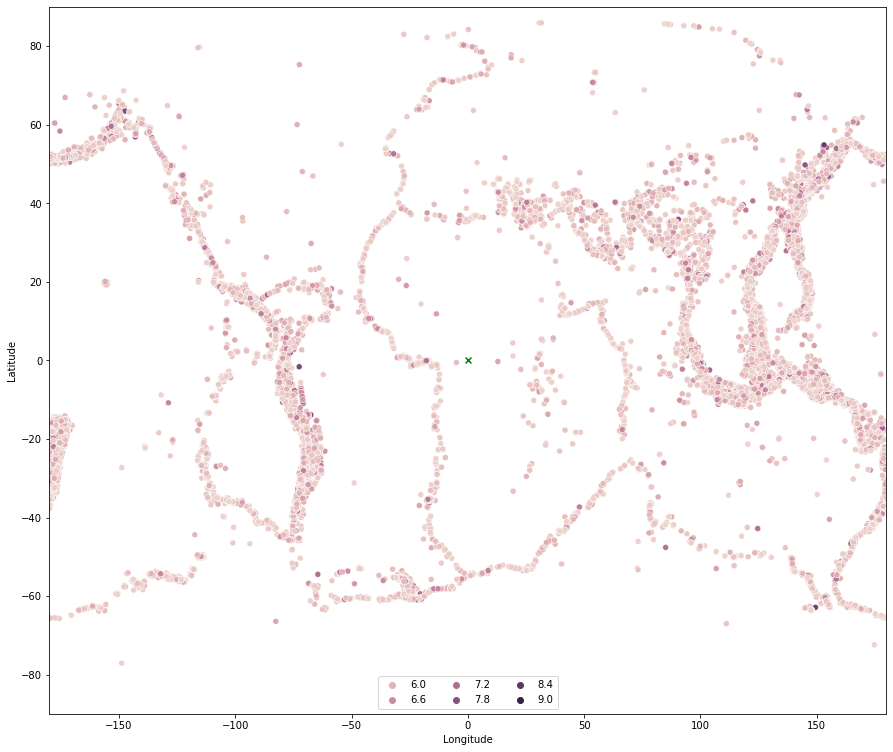

In [11]:
fig, ax = plt.subplots(figsize=(15,13))
sns.scatterplot(x=df['Longitude'], y=df['Latitude'], hue=df['Magnitude'], marker='o')
plt.legend(loc='lower center', ncol=3)
ax.scatter(x=0,y=0,marker='x', c='green')
ax.set_ylim([-90,90])
ax.set_xlim([-180,180])
# plt.savefig('images/earthquake_map.png', transparent=True, dpi=300)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [13]:
df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [14]:
df['Date_Time'] = df['Date'] + ' ' + df['Time']
df[20650:20700]

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,Date_Time
20650,2011-03-13T02:23:34.520Z,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,13.9,289.0,5.8,MWC,...,32.3,NaN,NaN,1.06,USP000HWQP,US,US,GCMT,Reviewed,2011-03-13T02:23:34.520Z 2011-03-13T02:23:34.520Z
20651,03/13/2011,07:56:43,39.642,143.181,Earthquake,13.0,NaN,358.0,5.7,MWB,...,39.9,NaN,NaN,0.92,USP000HWTG,US,US,US,Reviewed,03/13/2011 07:56:43
20652,03/13/2011,09:52:31,38.849,141.858,Earthquake,33.0,NaN,300.0,5.6,MWB,...,55.4,NaN,NaN,0.78,USP000HWUP,US,US,US,Reviewed,03/13/2011 09:52:31
20653,03/13/2011,11:37:30,37.348,142.394,Earthquake,17.0,NaN,435.0,5.7,MWW,...,26.8,NaN,NaN,0.78,USP000HWV9,US,US,US,Reviewed,03/13/2011 11:37:30
20654,03/13/2011,17:55:22,35.152,141.100,Earthquake,9.6,16.3,385.0,5.6,MWB,...,28.0,NaN,NaN,1.24,USP000HWYC,US,US,US,Reviewed,03/13/2011 17:55:22
20655,03/14/2011,01:02:39,36.408,140.894,Earthquake,11.0,NaN,417.0,5.5,MWB,...,30.7,NaN,NaN,0.80,USP000HX1E,US,US,US,Reviewed,03/14/2011 01:02:39
20656,03/14/2011,06:12:36,37.785,142.456,Earthquake,14.0,NaN,482.0,6.0,MWW,...,9.6,NaN,NaN,0.68,USP000HX38,US,US,US,Reviewed,03/14/2011 06:12:36
20657,03/14/2011,17:59:41,37.206,142.245,Earthquake,20.3,3.7,338.0,5.6,MWB,...,58.6,NaN,NaN,0.99,USP000HX7A,US,US,US,Reviewed,03/14/2011 17:59:41
20658,03/15/2011,09:49:53,37.367,142.301,Earthquake,8.0,NaN,558.0,5.8,MWW,...,14.2,NaN,NaN,0.78,USP000HXBC,US,US,US,Reviewed,03/15/2011 09:49:53
20659,03/15/2011,11:46:21,40.419,142.959,Earthquake,35.3,8.7,210.0,5.5,MWC,...,123.6,NaN,NaN,1.50,USP000HXBX,US,US,GCMT,Reviewed,03/15/2011 11:46:21


In [15]:
df_dt = df.drop('Date', axis=1).drop('Time', axis=1)
df_dt

,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,Date_Time
0,19.2460,145.6160,Earthquake,131.60,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,01/02/1965 13:44:18
1,1.8630,127.3520,Earthquake,80.00,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,01/04/1965 11:29:49
2,-20.5790,-173.9720,Earthquake,20.00,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,01/05/1965 18:05:58
3,-59.0760,-23.5570,Earthquake,15.00,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,01/08/1965 18:49:43
4,11.9380,126.4270,Earthquake,15.00,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,01/09/1965 13:32:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23407,38.3917,-118.8941,Earthquake,12.30,1.2,40.0,5.6,ML,0.320,18.0,42.47,0.120,NaN,0.1898,NN00570710,NN,NN,NN,Reviewed,12/28/2016 08:22:12
23408,38.3777,-118.8957,Earthquake,8.80,2.0,33.0,5.5,ML,0.260,18.0,48.58,0.129,NaN,0.2187,NN00570744,NN,NN,NN,Reviewed,12/28/2016 09:13:47
23409,36.9179,140.4262,Earthquake,10.00,1.8,NaN,5.9,MWW,NaN,NaN,91.00,0.992,4.8,1.5200,US10007NAF,US,US,US,Reviewed,12/28/2016 12:38:51
23410,-9.0283,118.6639,Earthquake,79.00,1.8,NaN,6.3,MWW,NaN,NaN,26.00,3.553,6.0,1.4300,US10007NL0,US,US,US,Reviewed,12/29/2016 22:30:19


In [16]:
dt = df_dt['Date_Time']
df_dt.drop('Date_Time', axis=1, inplace=True)
df_dt = pd.concat([dt, df_dt], axis=1)

In [17]:
#Rows 3378, 7512, 20650 have date-times in a different format, so we'll drop them.
df_dt['Date_Time'][20650]

'2011-03-13T02:23:34.520Z 2011-03-13T02:23:34.520Z'

In [18]:
df_dt.drop([3378,7512,20650], inplace=True)
df_dt['Date_Time'][20649:20651]

20652    03/13/2011 09:52:31
20653    03/13/2011 11:37:30
Name: Date_Time, dtype: object

In [19]:
df_dt.head()

,Date_Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965 13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965 11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965 18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965 18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965 13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [20]:
df_dt['Date_Time'] = pd.to_datetime(df_dt['Date_Time'])
df_dt.reset_index()
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23409 entries, 0 to 23411
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date_Time                   23409 non-null  datetime64[ns]
 1   Latitude                    23409 non-null  float64       
 2   Longitude                   23409 non-null  float64       
 3   Type                        23409 non-null  object        
 4   Depth                       23409 non-null  float64       
 5   Depth Error                 4460 non-null   float64       
 6   Depth Seismic Stations      7096 non-null   float64       
 7   Magnitude                   23409 non-null  float64       
 8   Magnitude Type              23406 non-null  object        
 9   Magnitude Error             327 non-null    float64       
 10  Magnitude Seismic Stations  2564 non-null   float64       
 11  Azimuthal Gap               7298 non-null   float64   

In [21]:
vc(df_dt,'Type')

TYPE
Earthquake           23229
Nuclear Explosion      175
Explosion                4
Rock Burst               1
Name: Type, dtype: int64


In [22]:
#dropping all entries that are not actual Earthquakes (no Nuclear Explosions, Explosions or Rock Bursts)
df_eq = df_dt[df_dt['Type'] == 'Earthquake'].reset_index(drop=True)

In [23]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23229 entries, 0 to 23228
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date_Time                   23229 non-null  datetime64[ns]
 1   Latitude                    23229 non-null  float64       
 2   Longitude                   23229 non-null  float64       
 3   Type                        23229 non-null  object        
 4   Depth                       23229 non-null  float64       
 5   Depth Error                 4448 non-null   float64       
 6   Depth Seismic Stations      7083 non-null   float64       
 7   Magnitude                   23229 non-null  float64       
 8   Magnitude Type              23226 non-null  object        
 9   Magnitude Error             315 non-null    float64       
 10  Magnitude Seismic Stations  2460 non-null   float64       
 11  Azimuthal Gap               7285 non-null   float64   

In [24]:
vc(df_eq,'Type')

TYPE
Earthquake    23229
Name: Type, dtype: int64


In [25]:
'''Multiple columns are missing too much data, so I will drop them here, "Type" is dropped because
all entries are "Earthquake" due to the way the data have thus far been processed.'''


drop_cols = ['Type','Depth Error','Depth Seismic Stations','Magnitude Error','Magnitude Seismic Stations','Azimuthal Gap',\
            'Horizontal Distance','Horizontal Error','Root Mean Square']

df_trim = df_eq.drop(drop_cols, axis=1)

In [26]:
vc(df_trim,"no",True)

DATE_TIME
1984-04-24 21:15:19    2
1984-08-14 01:02:08    2
1979-10-16 06:58:43    2
1994-02-16 06:48:58    2
1993-03-25 13:34:35    2
                      ..
2000-09-10 08:54:46    1
1992-09-05 20:06:42    1
2010-02-27 07:37:18    1
1992-11-01 10:03:16    1
1996-02-18 00:22:25    1
Name: Date_Time, Length: 23210, dtype: int64

LATITUDE
 51.500    5
-5.589     5
-5.902     5
-5.605     5
 1.271     4
          ..
 13.292    1
-13.273    1
-24.852    1
 12.598    1
-50.716    1
Name: Latitude, Length: 20531, dtype: int64

LONGITUDE
 126.777    5
 143.236    4
-174.922    4
-177.553    4
-178.409    4
           ..
 160.311    1
 169.666    1
 94.023     1
 131.882    1
 1.500      1
Name: Longitude, Length: 21310, dtype: int64

DEPTH
10.0     3911
33.0     3692
35.0      592
15.0      384
20.0      336
         ... 
588.5       1
194.5       1
84.4        1
126.5       1
446.9       1
Name: Depth, Length: 3482, dtype: int64

MAGNITUDE
5.50    4664
5.60    3941
5.70    3064
5.80    2327

In [27]:
'''
Only keeping entries from categorical columns with > 50 entries:
Magnitude Type:  MW,MWC,MB,MWB,MWW,MS,ML
Source:  US,ISCGEM,ISCGEMSUP,GCMT,NC
Location Source:  US,ISCGEM,GCMT,NC
Magnitude Source:  US,HRV,ISCGEM,GCMT,NC
'''

magtype = ['MW','MWC','MB','MWB','MWW','MS','ML']
source = ['US','ISCGEM','ISCGEMSUP','GCMT','NC']
locsrc = ['US','ISCGEM','GCMT','NC']
magsrc = ['US','HRV','ISCGEM','GCMT','NC']

In [28]:
df_trunc = df_trim[df_trim['Magnitude Type'].isin(magtype)]
df_trunc = df_trunc[df_trunc['Source'].isin(source)]
df_trunc = df_trunc[df_trunc['Location Source'].isin(locsrc)]
df_trunc = df_trunc[df_trunc['Magnitude Source'].isin(magsrc)]
df_trunc = df_trunc.reset_index(drop=True)

In [29]:
df_trunc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22820 entries, 0 to 22819
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date_Time         22820 non-null  datetime64[ns]
 1   Latitude          22820 non-null  float64       
 2   Longitude         22820 non-null  float64       
 3   Depth             22820 non-null  float64       
 4   Magnitude         22820 non-null  float64       
 5   Magnitude Type    22820 non-null  object        
 6   ID                22820 non-null  object        
 7   Source            22820 non-null  object        
 8   Location Source   22820 non-null  object        
 9   Magnitude Source  22820 non-null  object        
 10  Status            22820 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 1.9+ MB


In [30]:
'''
23412 entries to start.  Now that this has been cleaned up extensively, we have dropped down
to 22820 entries.  This is a loss of 592 entries, or 2.5%, so we have only trimmed off 2.5%
of the starting data.  I believe this is acceptable, based on the ~5% max that I'\ve been told
previously (although even this has been a bit inconsistent, but this is still a good number here).
'''

"\n23412 entries to start.  Now that this has been cleaned up extensively, we have dropped down\nto 22820 entries.  This is a loss of 592 entries, or 2.5%, so we have only trimmed off 2.5%\nof the starting data.  I believe this is acceptable, based on the ~5% max that I'\x0be been told\npreviously (although even this has been a bit inconsistent, but this is still a good number here).\n"

In [31]:
lat_15 = [-90,-75,-60,-45,-30,-15,0,15,30,45,60,75,90]
lat_30 = [-90,-60,-30,0,30,60,90]
long_15 = [-180,-165,-150,-135,-120,-105,-90,-75,-60,-45,-30,-15,0,
           15,30,45,60,75,90,105,120,135,150,165,180]
long_30 = [-180,-150,-120,-90,-60,-30,0,
           30,60,90,120,150,180]

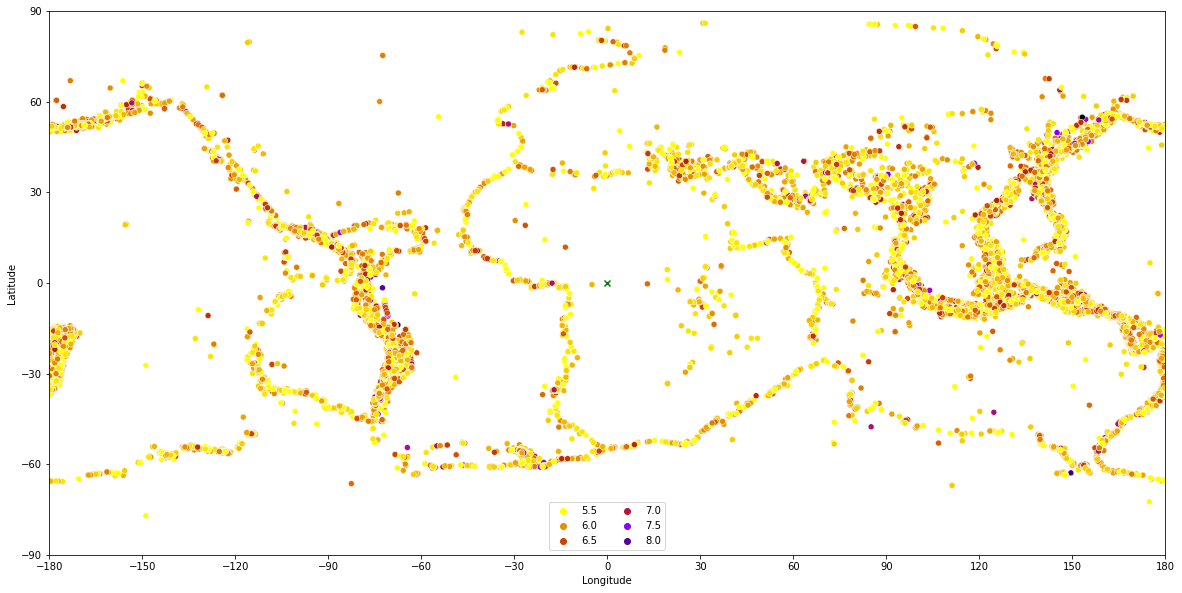

In [32]:
fig, ax = plt.subplots(figsize=(20,10))  # Not sure what the dimensions need to be to match a regular map yet
sns.scatterplot(x=df_trunc['Longitude'], y=df_trunc['Latitude'], hue=df_trunc['Magnitude'],
                marker='o',palette='gnuplot_r')
plt.legend(loc='lower center', ncol=2)
ax.scatter(x=0,y=0,marker='x', c='green')
ax.set_ylim([-90,90])
plt.yticks(lat_30)
ax.set_xlim([-180,180])
plt.xticks(long_30);
# plt.savefig('images/earthquake_map_trunc_autumn_r.png', transparent=True, dpi=300)
# gnuplot_r, brg_r, binary, autumn_r

#### Drastic improvements to the mapped earthquakes.

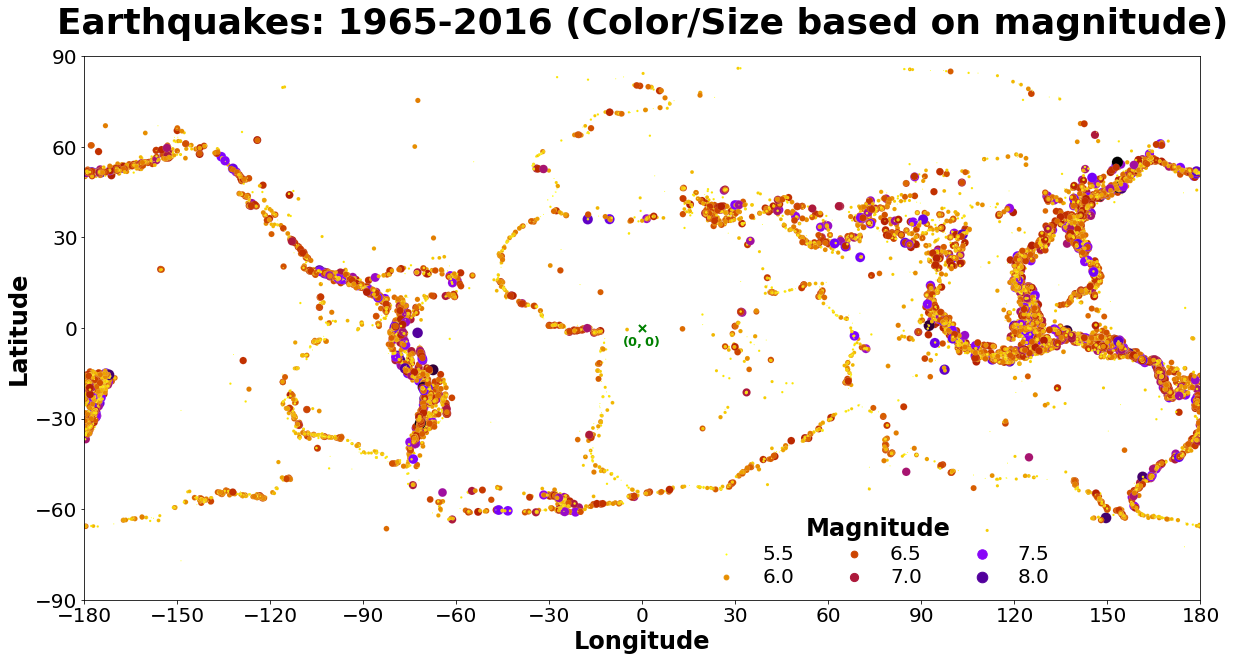

In [205]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df_trunc['Longitude'], y=df_trunc['Latitude'], hue=df_trunc['Magnitude'],
                size=df_trunc['Magnitude'], sizes=(1,125),marker='o',palette='gnuplot_r')
legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
                loc=(0.55,0.01), ncol=3, frameon=False, labelcolor='black')
plt.setp(legend.get_title(), color ='black', fontweight='bold')
ax.scatter(x=0,y=0, marker='x', c='green', s=(50), linewidths=2)
plt.annotate(xy=(-6.5,-6), text='$\\bf{(0,0)}$', fontsize=13, c='green')
ax.set_ylim([-90,90])
plt.title('Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Longitude', fontsize=24, fontweight='bold')
plt.yticks(lat_30, fontsize=20)
ax.set_xlim([-180,180])
plt.ylabel('Latitude', fontsize=24, fontweight='bold')
plt.xticks(ticks=(long_30), fontsize=20);
# plt.savefig('images/earthquake_map_binned_magn_125_dots_black.png', transparent=True, dpi=300)

## Feature Engineering

I want to see if binning this by month will do anything to bring results out, so I am going to attempt that here.

In [34]:
df_binned = df_trunc.copy()

df_binned['Month'] = pd.DatetimeIndex(df_binned['Date_Time']).month
df_binned.head()

,Date_Time,Latitude,Longitude,Depth,Magnitude,Magnitude Type,ID,Source,Location Source,Magnitude Source,Status,Month
0,1965-01-02 13:44:18,19.246,145.616,131.6,6.0,MW,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,1
1,1965-01-04 11:29:49,1.863,127.352,80.0,5.8,MW,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,1
2,1965-01-05 18:05:58,-20.579,-173.972,20.0,6.2,MW,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,1
3,1965-01-08 18:49:43,-59.076,-23.557,15.0,5.8,MW,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,1
4,1965-01-09 13:32:50,11.938,126.427,15.0,5.8,MW,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,1


Trying the same thing, but with Seasons, to see if that has any effect

In [35]:
season = {1 : 'Winter', 2 : 'Winter', 3 : 'Spring', 4 : 'Spring', 5 : 'Spring', 6 : 'Summer',
         7 : 'Summer', 8 : 'Summer', 9 : 'Fall', 10 : 'Fall', 11 : 'Fall', 12 : 'Winter'}

df_binned['Season'] = df_binned['Month'].map(season)
df_binned.head()

,Date_Time,Latitude,Longitude,Depth,Magnitude,Magnitude Type,ID,Source,Location Source,Magnitude Source,Status,Month,Season
0,1965-01-02 13:44:18,19.246,145.616,131.6,6.0,MW,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter
1,1965-01-04 11:29:49,1.863,127.352,80.0,5.8,MW,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter
2,1965-01-05 18:05:58,-20.579,-173.972,20.0,6.2,MW,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter
3,1965-01-08 18:49:43,-59.076,-23.557,15.0,5.8,MW,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter
4,1965-01-09 13:32:50,11.938,126.427,15.0,5.8,MW,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter


In [36]:
df_binned['Magnitude'].value_counts()

5.50    4566
5.60    3882
5.70    3017
5.80    2278
5.90    1893
6.00    1540
6.10    1182
6.20     894
6.30     754
6.40     568
6.50     453
6.60     358
6.70     307
6.80     232
6.90     179
7.00     165
7.10     118
7.20      99
7.30      62
7.40      59
7.60      48
7.50      41
7.70      39
7.80      28
7.90      19
8.00      13
8.10       7
8.20       6
8.30       5
5.64       1
6.45       1
5.73       1
6.02       1
6.57       1
5.97       1
5.66       1
5.88       1
Name: Magnitude, dtype: int64

Not sure how this will work out, but I want to make a single variable (I guess it will be a tuple) out of latitude/longitude to do a comparison with magnitude, and maybe frequency as well?

### Mixing Lat/Long won't work, so gonna have to try something different.

## Binning Magnitude to make a time-series model

In [37]:
df_magn = df_binned.copy()

def mag_bin(mag : float) -> int:
    
    #This function helps bin magnitude into a few different ranges
    
    if mag >= 5.5 and mag < 6:
        bins = 1
    elif mag >= 6 and mag < 7:
        bins = 2
    elif mag >= 7 and mag < 8:
        bins = 3
    else:
        bins = 4
    return bins

df_magn['Magn_Binned'] = df_magn['Magnitude'].apply(mag_bin)

## Since I'm targetting Asian countries for this, I need to create a df of just these countries.  So I need to isolate each earthquake by country.

In [38]:
# def is_asian(country):
#     asia = ['China','India','Indonesia','Pakistan','Bangladesh','Japan','Philippines',
#            'Vietnam']
#     if country in asia:
#         asian = 1
#     else:
#         asian = 0
#     return asian

In [39]:
# !pip install reverse_geocoder  '''This is only used once to create the csv.  Do not use again'''
# import reverse_geocoder as rg
# from pandas import DataFrame

# def reverseGeocode(coordinates):
#     return rg.search(coordinates)

# This next line grabs lots of info, based on Lat/Long.  It takes hours to run!!  The one run I made was saved as 'data/df_countries.csv', so use that for anything necessary!

# AND DO NOT UN-COMMENT IT OR I WILL COME FOR YOUR SOUL!

In [40]:
# DO NOT UNCOMMENT
'''
df_countries = df_magn.copy()
# df_countries['Country'] = df_countries['Lat_Long'].apply(reverseGeocode)
'''

"\ndf_countries = df_magn.copy()\n# df_countries['Country'] = df_countries['Lat_Long'].apply(reverseGeocode)\n"

In [41]:
# DO NOT UNCOMMENT
'''# df_countries.to_csv('data/df_countries.csv')'''

"# df_countries.to_csv('data/df_countries.csv')"

In [42]:
df_countries = pd.read_csv('data/df_countries.csv')
df_countries.head()

,Unnamed: 0,Date_Time,Latitude,Longitude,Depth,Magnitude,Magnitude Type,ID,Source,Location Source,Magnitude Source,Status,Month,Season,Magn_Binned,Lat_Long,Country
0,0,1965-01-02 13:44:18,19.246,145.616,131.6,6.0,MW,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,2,"(19.246, 145.616)","[{'lat': '15.21233', 'lon': '145.7545', 'name'..."
1,1,1965-01-04 11:29:49,1.863,127.352,80.0,5.8,MW,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(1.8630000000000002, 127.352)","[{'lat': '1.49305', 'lon': '127.55149', 'name'..."
2,2,1965-01-05 18:05:58,-20.579,-173.972,20.0,6.2,MW,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,2,"(-20.579, -173.972)","[{'lat': '-19.81468', 'lon': '-174.35423', 'na..."
3,3,1965-01-08 18:49:43,-59.076,-23.557,15.0,5.8,MW,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(-59.076, -23.557)","[{'lat': '-54.28111', 'lon': '-36.5092', 'name..."
4,4,1965-01-09 13:32:50,11.938,126.427,15.0,5.8,MW,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(11.937999999999999, 126.427)","[{'lat': '12.062', 'lon': '125.4881', 'name': ..."


In [43]:
# The Data from the above mining only provides the country code, in the middle of a long string,
#     So the cc must be extracted, and then converted

# !pip install country_converter
import country_converter as coco

def get_cc (info_string : str) -> str:
    cc_pre = (info_string.split("'cc': '",1)[1])
    cc = cc_pre[:-3]
    return cc

def convert_cc (cc : str) -> str:
    name = coco.convert(names=cc, to='name_short')
    return name

In [44]:
df_countries['Country_Code'] = df_countries['Country'].apply(get_cc)

# The following takes a bit, and only needs to be run once.  The resultant df is converted to a saved csv file, which can just be pulled in the future.

In [45]:
'''
# Don't run the following.  It has already been completed and a csv has been saved:
("fixed_countries.csv)")

# Now convert cc to country names

# df_countries['Country'] = df_countries['Country_Code'].apply(convert_cc)
'''

'\n# Don\'t run the following.  It has already been completed and a csv has been saved:\n("fixed_countries.csv)")\n\n# Now convert cc to country names\n\n# df_countries[\'Country\'] = df_countries[\'Country_Code\'].apply(convert_cc)\n'

In [46]:
'''
# Do not un-comment the following.  It saved the above converted df.  It should just be
# imported at this point.

# df_countries.to_csv('data/fixed_countries.csv')
'''

"\n# Do not un-comment the following.  It saved the above converted df.  It should just be\n# imported at this point.\n\n# df_countries.to_csv('data/fixed_countries.csv')\n"

In [47]:
df_countries = pd.read_csv('data/fixed_countries.csv')

### Now we can identify each earthquake as occurring in asia, by using the following function to check for presence in the following [list of asian countries](https://www.countries-ofthe-world.com/countries-of-asia.html):

In [48]:
def is_asian(country):
    asia = ['Afghanistan','Armernia','Azerbaijan','Bahrain','Bangladesh','Bhutan','Brunei',
           'Cambodia','China','Cyprus','Georgia','India','Indonesia','Iran','Irag','Israel',
           'Japan','Jordan','Kazakhstan','Kuwait','Kyrgyzstan','Laos','Lebanon','Malaysia',
           'Maldives','Mongolia','Myanmar','Nepal','North Korea','Oman','Pakistan','Palestine',
           'Philippines','Qatar','Russia','Saudi Arabia','Singapore','South Korea','Sri Lanka',
           'Syria','Taiwan','Tajikistan','Thailand','Timor-Leste','Turkey','Turkmenistan','UAE',
           'United Arab Emirates','United Arab Emirates (UAE)','Uzbekistan','Vietnam','Yemen']
    if country in asia:
        asian = 1
    else:
        asian = 0
    return asian

In [49]:
df_countries['In_Asia'] = df_countries['Country'].apply(is_asian)

In [50]:
df_countries.head()

,Unnamed: 0,Unnamed: 0.1,Date_Time,Latitude,Longitude,Depth,Magnitude,Magnitude Type,ID,Source,Location Source,Magnitude Source,Status,Month,Season,Magn_Binned,Lat_Long,Country,Country_Code,In_Asia
0,0,0,1965-01-02 13:44:18,19.246,145.616,131.6,6.0,MW,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,2,"(19.246, 145.616)",Northern Mariana Islands,MP,0
1,1,1,1965-01-04 11:29:49,1.863,127.352,80.0,5.8,MW,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(1.8630000000000002, 127.352)",Indonesia,ID,1
2,2,2,1965-01-05 18:05:58,-20.579,-173.972,20.0,6.2,MW,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,2,"(-20.579, -173.972)",Tonga,TO,0
3,3,3,1965-01-08 18:49:43,-59.076,-23.557,15.0,5.8,MW,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(-59.076, -23.557)",South Georgia and South Sandwich Is.,GS,0
4,4,4,1965-01-09 13:32:50,11.938,126.427,15.0,5.8,MW,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(11.937999999999999, 126.427)",Philippines,PH,1


In [51]:
total_earthquakes = len(df_countries)
asian_earthquakes = df_countries['In_Asia'].value_counts()[1]
non_asian_earthquakes = df_countries['In_Asia'].value_counts()[0]
percent_asian = round(df_countries['In_Asia'].value_counts('1')[1] * 100, 2)

print('There are ' + str(total_earthquakes) + ' earthquakes in the initial data set.')
print(str(asian_earthquakes) + ' of these occurred in Asian countries,')
print('leaving ' + str(non_asian_earthquakes) + ' occurring in the rest of the world.')
print('This means that earthquakes in Asia accounted for ' + str(percent_asian) + '% of the\
 world total from 1965 through 2016.')

There are 22820 earthquakes in the initial data set.
8804 of these occurred in Asian countries,
leaving 14016 occurring in the rest of the world.
This means that earthquakes in Asia accounted for 38.58% of the world total from 1965 through 2016.


In [52]:
df_asian = df_countries[df_countries['In_Asia'] == 1].reset_index(drop=True)
df_asian

,Unnamed: 0,Unnamed: 0.1,Date_Time,Latitude,Longitude,Depth,Magnitude,Magnitude Type,ID,Source,Location Source,Magnitude Source,Status,Month,Season,Magn_Binned,Lat_Long,Country,Country_Code,In_Asia
0,1,1,1965-01-04 11:29:49,1.8630,127.3520,80.00,5.8,MW,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(1.8630000000000002, 127.352)",Indonesia,ID,1
1,4,4,1965-01-09 13:32:50,11.9380,126.4270,15.00,5.8,MW,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(11.937999999999999, 126.427)",Philippines,PH,1
2,6,6,1965-01-12 13:32:25,27.3570,87.8670,20.00,5.9,MW,ISCGEM861007,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(27.357, 87.867)",India,IN,1
3,10,10,1965-01-17 20:57:41,-6.8070,108.9880,227.90,5.9,MW,ISCGEM861155,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(-6.807, 108.988)",Indonesia,ID,1
4,11,11,1965-01-24 00:11:17,-2.6080,125.9520,20.00,8.2,MW,ISCGEM861299,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,4,"(-2.608, 125.95200000000001)",Indonesia,ID,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8799,22807,22807,2016-12-20 10:04:39,37.1442,84.9583,10.00,5.6,MWW,US200082S5,US,US,US,Reviewed,12,Winter,1,"(37.1442, 84.9583)",China,CN,1
8800,22810,22810,2016-12-21 00:17:15,-7.5082,127.9206,152.00,6.7,MWW,US10007LKW,US,US,US,Reviewed,12,Winter,2,"(-7.5082, 127.9206)",Timor-Leste,TL,1
8801,22817,22817,2016-12-28 12:38:51,36.9179,140.4262,10.00,5.9,MWW,US10007NAF,US,US,US,Reviewed,12,Winter,1,"(36.9179, 140.4262)",Japan,JP,1
8802,22818,22818,2016-12-29 22:30:19,-9.0283,118.6639,79.00,6.3,MWW,US10007NL0,US,US,US,Reviewed,12,Winter,2,"(-9.0283, 118.6639)",Indonesia,ID,1


In [53]:
#  Oops!  Extra indices from the two "big" engineered features.  Dropping:

drop_indices = ['Unnamed: 0','Unnamed: 0.1']
df_asian = df_asian.drop(drop_indices, axis=1)

In [54]:
df_asian.head()

,Date_Time,Latitude,Longitude,Depth,Magnitude,Magnitude Type,ID,Source,Location Source,Magnitude Source,Status,Month,Season,Magn_Binned,Lat_Long,Country,Country_Code,In_Asia
0,1965-01-04 11:29:49,1.863,127.352,80.0,5.8,MW,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(1.8630000000000002, 127.352)",Indonesia,ID,1
1,1965-01-09 13:32:50,11.938,126.427,15.0,5.8,MW,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(11.937999999999999, 126.427)",Philippines,PH,1
2,1965-01-12 13:32:25,27.357,87.867,20.0,5.9,MW,ISCGEM861007,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(27.357, 87.867)",India,IN,1
3,1965-01-17 20:57:41,-6.807,108.988,227.9,5.9,MW,ISCGEM861155,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,1,"(-6.807, 108.988)",Indonesia,ID,1
4,1965-01-24 00:11:17,-2.608,125.952,20.0,8.2,MW,ISCGEM861299,ISCGEM,ISCGEM,ISCGEM,Automatic,1,Winter,4,"(-2.608, 125.95200000000001)",Indonesia,ID,1


In [56]:
df_asian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8804 entries, 0 to 8803
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date_Time         8804 non-null   object 
 1   Latitude          8804 non-null   float64
 2   Longitude         8804 non-null   float64
 3   Depth             8804 non-null   float64
 4   Magnitude         8804 non-null   float64
 5   Magnitude Type    8804 non-null   object 
 6   ID                8804 non-null   object 
 7   Source            8804 non-null   object 
 8   Location Source   8804 non-null   object 
 9   Magnitude Source  8804 non-null   object 
 10  Status            8804 non-null   object 
 11  Month             8804 non-null   int64  
 12  Season            8804 non-null   object 
 13  Magn_Binned       8804 non-null   int64  
 14  Lat_Long          8804 non-null   object 
 15  Country           8804 non-null   object 
 16  Country_Code      8804 non-null   object 


### Plot of Asian Earthquakes

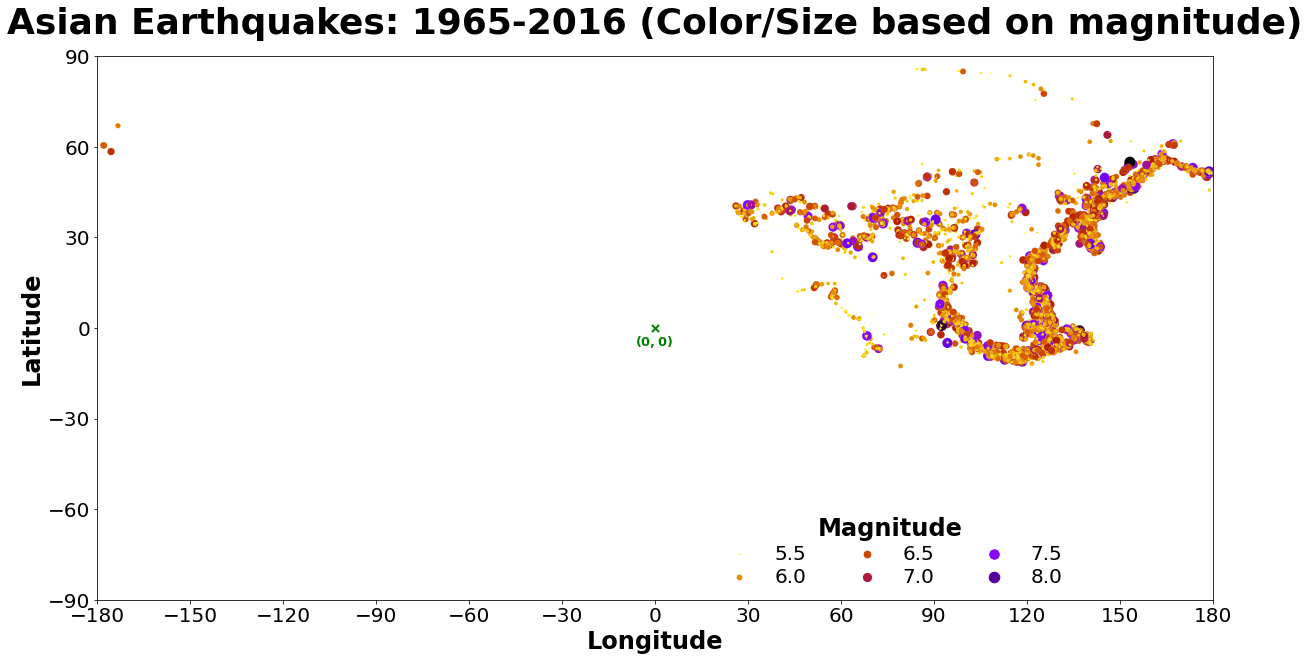

In [201]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df_asian['Longitude'], y=df_asian['Latitude'], hue=df_asian['Magnitude'],
                size=df_asian['Magnitude'], sizes=(1,125),marker='o',palette='gnuplot_r')
legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
                loc=(0.55,0.01), ncol=3, frameon=False, labelcolor='black')
plt.setp(legend.get_title(), color ='black', fontweight='bold')
ax.scatter(x=0,y=0, marker='x', c='green', s=(50), linewidths=2)
plt.annotate(xy=(-6.5,-6), text='$\\bf{(0,0)}$', fontsize=13, c='green')
ax.set_ylim([-90,90])
plt.title('Asian Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Longitude', fontsize=24, fontweight='bold')
plt.yticks(lat_30, fontsize=20)
ax.set_xlim([-180,180])
plt.ylabel('Latitude', fontsize=24, fontweight='bold')
plt.xticks(ticks=(long_30), fontsize=20);
# plt.savefig('images/earthquake_map_asian_black_125dot.png', transparent=True, dpi=300)

#### Somehow, the Date_Time column was re-converted to "object" so I'll fix that now, and since we'll be doing Time-Series, I'll start setting up the Series necessary to show binned magnitudes over time:

In [66]:
df_asian['Date_Time'] = pd.to_datetime(df_asian['Date_Time']).reset_index(drop=True)
# asian_eq_ts = pd.Series(df_asian.set_index(df_asian['Date_Time'])['Magn_Binned'])
# asian_eq_ts

Date_Time
1965-01-04 11:29:49    1
1965-01-09 13:32:50    1
1965-01-12 13:32:25    1
1965-01-17 20:57:41    1
1965-01-24 00:11:17    4
                      ..
2016-12-20 10:04:39    1
2016-12-21 00:17:15    2
2016-12-28 12:38:51    1
2016-12-29 22:30:19    2
2016-12-30 20:08:28    1
Name: Magn_Binned, Length: 8804, dtype: int64

In [68]:
# asian_eq_ts.plot(ylabel='Magnitude Bin')
df_asian['Magn_Binned'].value_counts()

1    6068
2    2443
3     283
4      10
Name: Magn_Binned, dtype: int64

In [73]:
df_asian_Mag1 = df_asian[df_asian['Magn_Binned'] == 1].reset_index(drop=True)
df_asian_Mag2 = df_asian[df_asian['Magn_Binned'] == 2].reset_index(drop=True)
df_asian_Mag3 = df_asian[df_asian['Magn_Binned'] == 3].reset_index(drop=True)
df_asian_Mag4 = df_asian[df_asian['Magn_Binned'] == 4].reset_index(drop=True)

In [78]:
mag1_ts = pd.Series(df_asian_Mag1.set_index(df_asian_Mag1['Date_Time'])['Magnitude'])
mag2_ts = pd.Series(df_asian_Mag2.set_index(df_asian_Mag2['Date_Time'])['Magnitude'])
mag3_ts = pd.Series(df_asian_Mag3.set_index(df_asian_Mag3['Date_Time'])['Magnitude'])
mag4_ts = pd.Series(df_asian_Mag4.set_index(df_asian_Mag4['Date_Time'])['Magnitude'])

In [140]:
mag2_ts

Date_Time
1965-02-02 15:56:51    6.0
1965-02-04 06:04:59    6.0
1965-02-04 12:06:08    6.5
1965-02-04 14:18:29    6.4
1965-02-05 09:32:11    6.3
                      ... 
2016-12-05 01:13:05    6.3
2016-12-06 22:03:33    6.5
2016-12-08 05:15:05    6.0
2016-12-21 00:17:15    6.7
2016-12-29 22:30:19    6.3
Name: Magnitude, Length: 2443, dtype: float64

### Now that I have all the ranges of magnitudes of earthquakes in time-series form, I can start playing with them and plotting them!

In [206]:
weekly_mag1 = mag1_ts.resample('M').sum()
weekly_mag2 = mag2_ts.resample('M').sum()
weekly_mag3 = mag3_ts.resample('M').sum()
weekly_mag4 = mag4_ts.resample('M').sum()

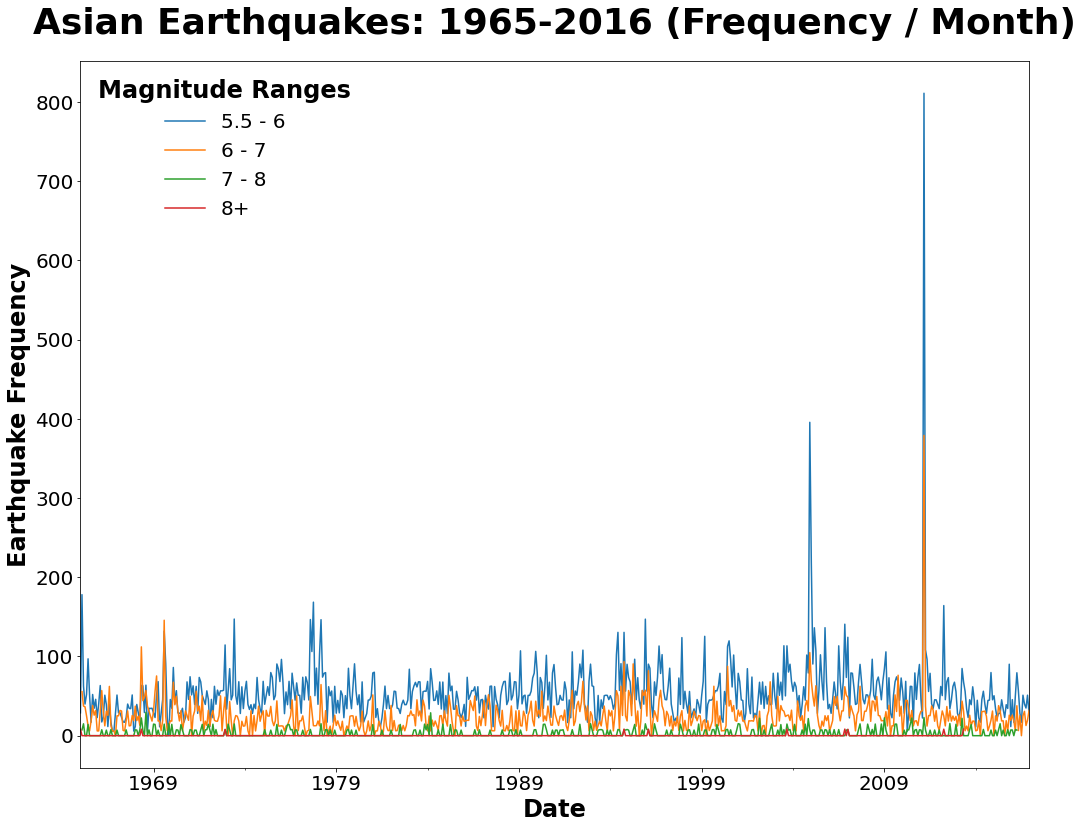

In [208]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17,13))
weekly_mag1.plot(ax = ax, ylabel='Counts')
weekly_mag2.plot(ax = ax)
weekly_mag3.plot(ax = ax)
weekly_mag4.plot(ax = ax)
legend = plt.legend(title='Magnitude Ranges', title_fontsize=24, fontsize=20,
                    frameon=False, loc='best', labels=['5.5 - 6','6 - 7','7 - 8','8+'])
plt.setp(legend.get_title(), fontweight='bold')
plt.title('Asian Earthquakes: 1965-2016 (Frequency / Month)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Date', fontsize=24, fontweight='bold')
plt.xticks(fontsize=20)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# for label in ax.get_xticklabels(which='major'):
#     label.set(rotation=30, horizontalalignment='right')
plt.ylabel('Earthquake Frequency', fontsize=24, fontweight='bold')
plt.yticks(fontsize=20);


''

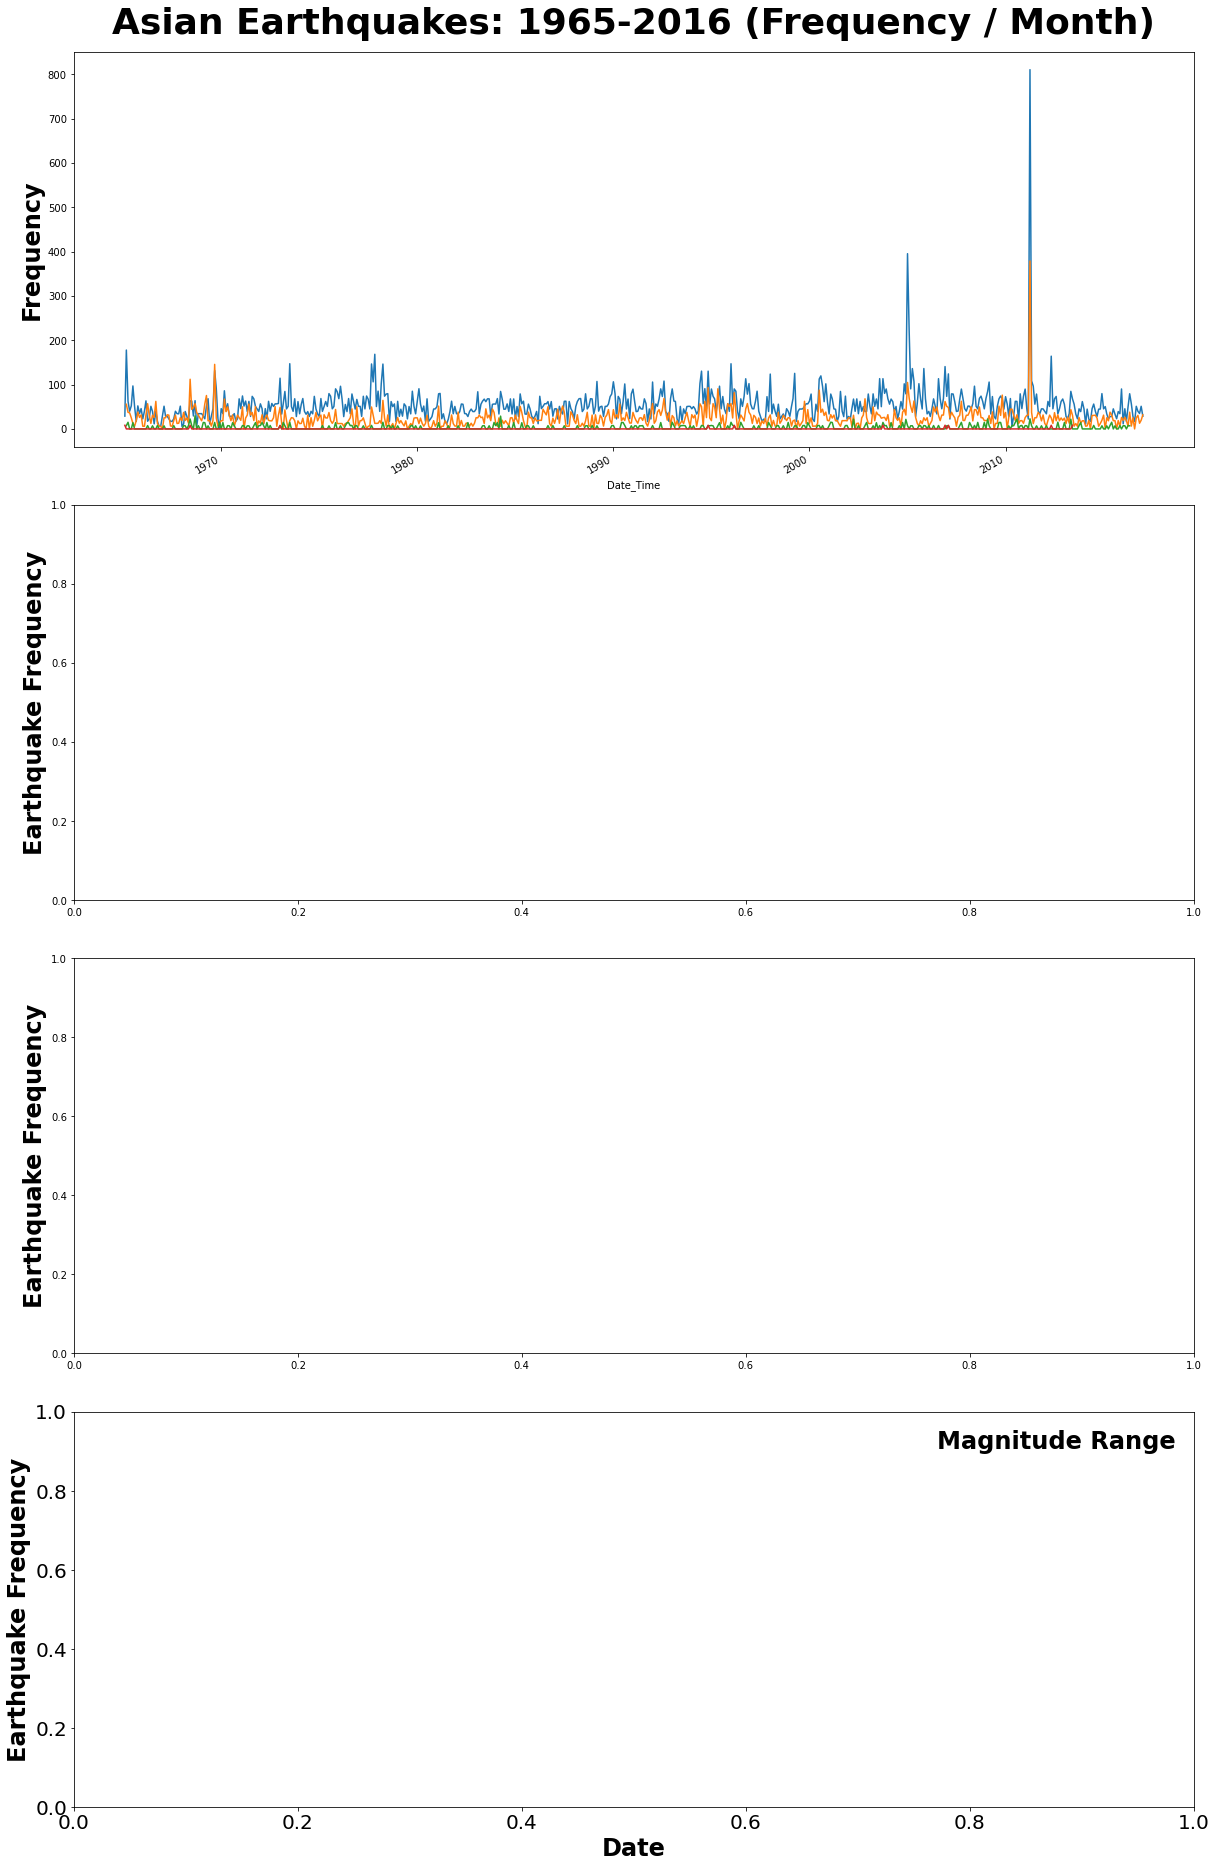

In [209]:
fig, axes = plt.subplots(4,1, figsize=(17,26), tight_layout=True)

for ax in axes:
    ax.set_ylabel('Earthquake Frequency', fontsize=24, fontweight='bold')

ax = axes[0]
ax.set_title('Asian Earthquakes: 1965-2016 (Frequency / Month)', fontsize=36,
          fontweight='bold', y=1.03)
ax.plot(weekly_mag1)
ax.set_xlabel('')
ax.set_ylabel('Frequency', fontsize=24, fontweight='bold')





legend = plt.legend(title='Magnitude Range', title_fontsize=24, fontsize=20,
                    frameon=False, loc='best', labels=['5.5 - 6','6 - 7','7 - 8','8+'])
plt.setp(legend.get_title(), fontweight='bold')
plt.xlabel('Date', fontsize=24, fontweight='bold')
plt.xticks(fontsize=20)
plt.ylabel('Earthquake Frequency', fontsize=24, fontweight='bold')
plt.yticks(fontsize=20);

weekly_mag2.plot(ax = ax);
weekly_mag3.plot(ax = ax);
weekly_mag4.plot(ax = ax);
;

# For right now, I'm moving on to some suggestions that Max, subbing for Jelly, gave to me.  Can come back to the above, later, if necessary

In [222]:
# Going to look at all points together, instead of binning the magnitude ranges, per Max

asian_ts = pd.Series(df_asian.set_index(df_asian['Date_Time'])['Magnitude'])

# And now we'll resample to Monthly sum and see how it looks

monthly_sum_asian = asian_ts.resample('M').sum()

# We'll make a Monthly mean now too for funsies

monthly_mean_asian = asian_ts.resample('M').mean()

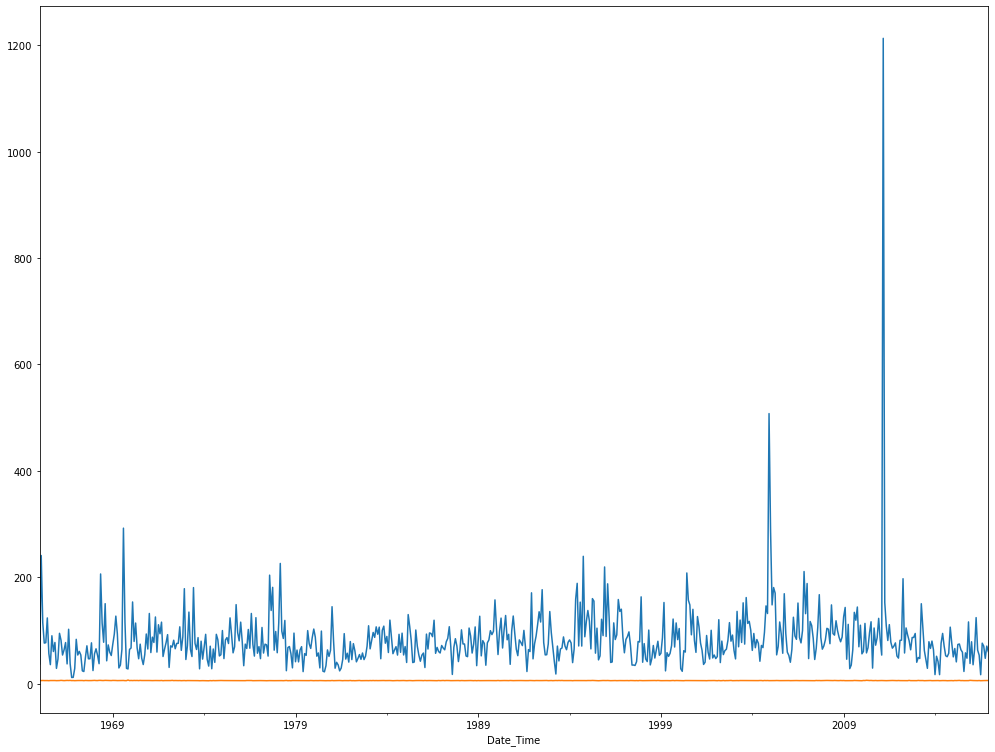

In [224]:
fig, ax = plt.subplots(figsize=(17,13))

monthly_sum_asian.plot(ax=ax);
monthly_mean_asian.plot(ax=ax);

#### Dickey-Fuller

In [227]:
from statsmodels.tsa.stattools import adfuller

def run_df(ts):
    df_rslt = adfuller(ts)
    print("Dickey_Fuller test results:  \n")
    df_output = pd.Series(df_rslt[0:4], index=['Test Statistic','p-value',\
                                              '#Lags Used','Number of Observations Used'])
    for key, value in df_rslt[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

In [228]:
run_df(asian_ts)

Dickey_Fuller test results:  

Test Statistic                  -20.419307
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    8789.000000
Critical Value (1%)              -3.431094
Critical Value (5%)              -2.861869
Critical Value (10%)             -2.566945
dtype: float64
